In [1]:
import GPy
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm
import scipy
from scipy.interpolate import interp2d
import seaborn as sns
from math import nan, isnan

import tensorflow as tf
import tf_agents
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()
np.random.seed(1)
random.seed(1)

In [62]:
def flatten(liste):
    return [item for sublist in liste for item in sublist]

def preprocessing(X_s):
    X = []
    for liste in X_s:
        X += liste.copy()
    return np.array(X)

def copy_X_D(X_D):
    X = []
    for liste in X_D:
        X.append(liste.copy())
    return np.array(X)

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def distance(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
        
def sigma_matrix(gp_model, X_v):
    return gp_model.kern.K(X_v, X_v)
    
def sigma_prime_matrix(gp_model, X_v, X_s):
    kernel = gp_model.rbf
    variance_n = float(gp_model.Gaussian_noise.variance)
    a = kernel.K(X_v, X_v)
    try:
        b = kernel.K(X_v, X_s)
    except:
        print(X_v)
        print("#######")
        print(X_s)
    c = kernel.K(X_s, X_s)
    d = variance_n*np.eye(len(X_s))
    e = kernel.K(X_s, X_v)
    f = np.linalg.inv(c + d)
    g = np.dot(b, f)
    h = np.dot(g, e)
    return a - h

def f_D(gp_model, X_v, X_s):
    sigma = sigma_matrix(gp_model, X_v)
    sigma_prime = sigma_prime_matrix(gp_model, X_v, X_s)
    return 0.5 * (np.log(np.linalg.det(sigma)) - np.log(np.linalg.det(sigma_prime)))

def reward_function(gp_model, X_v, X_s_old, X_s_new):
    if len(X_s_old)==0:
        sigma_prime_old = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_old = sigma_prime_matrix(gp_model, X_v, X_s_old)
    if len(X_s_new)==0:
        sigma_prime_new = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_new = sigma_prime_matrix(gp_model, X_v, X_s_new)
    return 0.5 * (np.log(np.linalg.det(sigma_prime_old)) - np.log(np.linalg.det(sigma_prime_new)))

def credit_assignment(env, reward, dones):
    if env.nb_agents==1:
        return np.array([reward])
    rewards = np.zeros(env.nb_agents)
    if reward==0:
        return rewards
    X_s = preprocessing(env.X_s)
    H = np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s)))
    for i in range(env.nb_agents):
        if not dones[i]:
            X_s_i = env.X_s.copy()
            del X_s_i[i]
            X_s_i = preprocessing(X_s_i)
            if len(X_s_i)==0:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_matrix(env.gp_model, env.X_v))) - H)
            else:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s_i))) - H)
    somme = np.sum(rewards)
    if somme==0:
        return rewards
    return rewards*(reward/(np.sum(rewards)))

def construct_graph(graph_dim, graph_unity):
    x = graph_dim[0]
    y = graph_dim[1]
    i, j = 0.0, 0.0
    graph = nx.Graph()
    for k in range(x*y):
        graph.add_node(k, coord=[i, j])
        i += graph_unity
        if i==x*graph_unity:
            i = 0.0
            j += graph_unity
    for k in range(x*y):
        if (k+1)%x!=0:
            graph.add_edge(k, k+1)
        if k<x*y-x:
            graph.add_edge(k, k+x)
    return graph
            
def show_graph(graph):
    nx.draw(graph, with_labels=True, font_weight='bold')

def remove_nodes_from_graph(graph, liste):
    graph.remove_nodes_from(liste)
    return graph

def pollutant_concentration(x, y, z, Q, u, h_s, g, V, T_a, T_s, a_y, b_y, a_z, b_z):
    if x==0:
        x = 0.7
    sigma_y = sigma_function(x, a_y, b_y)
    sigma_z = sigma_function(x, a_z, b_z)
    H = h_s + delta_h(x, u, g, V, T_a, T_s)
    return (Q/(2*np.pi*u*sigma_y*sigma_z))*np.exp(-y**2/(2*sigma_y))*(np.exp(-(z-H)**2/(2*sigma_y))+np.exp(-(z+H)**2/(2*sigma_y)))

def sigma_function(x, a, b):
    return a * (abs(x) ** b)

def delta_h(x, u, g, V, T_a, T_s):
    F = (g/np.pi) * V * ((T_s - T_a)/T_s)
    return (1.6 * (F**(1/3)) * (x**(2/3))) / u

def incertitude_initiale(sigma, graph):
    return 0.5 * np.log(np.linalg.det(sigma)) + (graph.number_of_nodes()/2) * (1 + np.log(2*np.pi))

def plot_heat_map(means, graph_dim, ax=None):
    means = np.reshape(np.array(means), (graph_dim[0],graph_dim[1]))
    ax = sns.heatmap(means, linewidth = 0, cmap = 'coolwarm', ax=ax)
    ax.invert_yaxis()
    plt.show()
    
def find_lengthscale(x1, x2, y, var):
    return distance(x1, x2) * np.sqrt(-1/np.log(y/var))

In [50]:
def collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance, lengthscale, measurement_scale):
    X_D = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    simulation_kernel = GPy.kern.RBF(input_dim = 2, variance=variance, lengthscale=lengthscale)
    cov = simulation_kernel.K(X_D)
    X, Y = [], []
    for _ in range(exploration_steps):
        Y_D = np.random.multivariate_normal(np.array(means)*measurement_scale, cov, 1)[0]
        Y_D = np.reshape(Y_D, (len(Y_D),1))
        Y_D[Y_D<0] = 1e-5
        sparse_nodes = random.sample(range(0, graph.number_of_nodes()), nb_agents)
        X.append(X_D[sparse_nodes])
        Y.append(Y_D[sparse_nodes])
    return incertitude_initiale(cov, graph), np.array(X), np.array(Y)

def scipy_spatial_interpolation(X, Y, kind='linear'): #linear (4 points) cubic (25 points) or quintic (36 points)
    cartes = []
    for i in range(len(X)):
        x, y, z = X[i][:,0], X[i][:,1], np.reshape(Y[i], (len(Y[i]),))
        cartes.append(interp2d(x, y, z, kind=kind))
    return cartes

def gpy_spatial_interpolation(X, Y):
    gp_models = []
    for i in range(len(X)):
        kernel = GPy.kern.RBF(2)
        gp_models.append(GPy.models.GPRegression(X[i], Y[i], kernel)) ##### SparseGPRegression or GPRegression
        gp_models[-1].optimize(messages=False)
    return gp_models

def predicted_scipy_map(carte, graph, graph_dim, measurements_scale, plot=False):
    predictions = []
    X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    for coord in X_v:
        prediction = carte(coord[0], coord[1])[0]/measurements_scale
        if prediction<0:
            prediction = 1e-5
        predictions.append(prediction)
    if plot:
        plot_heat_map(predictions, graph_dim)
    return predictions

def predicted_gpy_map(gp_model, graph, graph_dim, measurements_scale, plot=False):
    X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    predictions = np.reshape(gp_model.predict(X_v)[0], (graph.number_of_nodes(),))/measurements_scale
    predictions[predictions<0] = 1e-5
    if plot:
        plot_heat_map(predictions, graph_dim)
    return predictions

def hyperparameters_estimator(model, graph, graph_dim, measurements_scale, kind="scipy"): #gpy
    X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    predictions = []
    x = copy_X_D(X_v)
    for i in range(len(model)-1):
        x = np.concatenate((x,X_v))
    for ele in model:
        if kind=="gpy":
            predictions.append(predicted_gpy_map(ele, graph, graph_dim, measurements_scale=1))
        else:
            predictions.append(predicted_scipy_map(ele, graph, graph_dim, measurements_scale=1))
    predictions = np.reshape(np.array(predictions).T, (graph.number_of_nodes(), len(model)))
    cov = np.cov(predictions)
    var, var_inf, var_sup =  mean_confidence_interval(np.diag(cov), confidence=0.95)
    #################
    lengthscales = []
    for i in range(len(cov)):
        for j in range(len(cov)):
            if i!=j:
                l = find_lengthscale(X_v[i], X_v[j], cov[i][j], var)
                if not np.isnan(l):
                    lengthscales.append(l)
    lengthscale, lengthscale_inf, lengthscale_sup =  mean_confidence_interval(lengthscales, confidence=0.95)
    return cov, (var, var_inf, var_sup), (lengthscale, min(lengthscales), max(lengthscales)), x, predictions

def adjustment(graph, cov, info_var, info_lengthscale, var_granularity, lengthscale_granularity):
    X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    err, v, l = float("inf"), 0, 0
    for i in tqdm(np.linspace(info_var[1], info_var[2], var_granularity)):
        for j in np.linspace(info_lengthscale[1], info_lengthscale[2], lengthscale_granularity):
            k = GPy.kern.RBF(2, variance=i, lengthscale=j)
            mse = np.sum((k.K(X_v)-cov)**2)
            if mse<err:
                v, l, err = i, j, mse
    return v, l

In [81]:
graph_dim = (5, 5)
graph_unity = 1
graph = construct_graph(graph_dim, graph_unity)
X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
means = [6, 3, 2, 1.5, 1, 3, 2.75, 2.5, 1.75, 1.125, 2, 2.5, 2.25, 2, 1.25, 1.5, 1.75, 2, 1.75, 1.5, 1, 1.125, 1.25, 1.5, 1.25]
nb_agents = 4
exploration_steps = 25
variance = 12
lengthscale = 1.5
measurements_scale = 1

incertitude, x, y = collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance, lengthscale, measurements_scale)
scipy_res = scipy_spatial_interpolation(x, y)
#gpy_res = gpy_spatial_interpolation(x, y)

#predicted_scipy_map(scipy_res[0], graph, graph_dim, measurements_scale, plot=False)
#pred = predicted_gpy_map(gpy_res[0], graph, graph_dim, measurements_scale, plot=False)

cov, info_var, info_lengthscale, xx, yy = hyperparameters_estimator(scipy_res, graph, graph_dim, measurements_scale, kind="scipy")
print(info_var)
print(info_lengthscale)

#var, lengthscale = adjustment(graph, cov, info_var, info_lengthscale, 100, 100)
#print(var, lengthscale)
#var, lengthscale = info_var[0], info_lengthscale[1]

x = np.reshape(x, (nb_agents*exploration_steps,2))
y = np.reshape(y, (nb_agents*exploration_steps,1))
kernel = GPy.kern.RBF(input_dim = 2)
gp_model = GPy.models.GPRegression(x, y, kernel)
gp_model.optimize(messages = False)
display(gp_model)

#x = np.reshape(x, (nb_agents*exploration_steps,2))
#y = np.reshape(y, (nb_agents*exploration_steps,1))
#kernel = GPy.kern.RBF(2, variance=var, lengthscale=lengthscale)
#gp_model = GPy.models.GPRegression(x, y, kernel, noise_var=0)

print(gp_model.predict(np.array([[0, 0]]))[0])
print(gp_model.predict(np.array([[4, 4]]))[0])
print("Incertitude initiale : ", incertitude_initiale(sigma_matrix(gp_model, X_v), graph))

(12.48422787506176, 10.277054954847733, 14.691400795275788)
(2.7385015333289378, 0.9801869758904403, 5.978994124009085)


 C:\Users\hm_as\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning:The required storage space exceeds the available storage space.
Probable causes: nxest or nyest too small or s is too small. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=4 fp=0.237740 s=0.000000
 C:\Users\hm_as\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning:The required storage space exceeds the available storage space.
Probable causes: nxest or nyest too small or s is too small. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=4 fp=2.938744 s=0.000000
 C:\Users\hm_as\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning:The required storage space exceeds the available storage space.
Probable causes: nxest or nyest too small or s is too small. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=4 fp=0.150518 s=0.000000
 C:\Users\hm_as\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning:The required storage space exceeds the available storage space.


GP_regression.,value,constraints,priors
rbf.variance,8.301086609854377,+ve,
rbf.lengthscale,3.2826055826802283,+ve,
Gaussian_noise.variance,6.414159698154335,+ve,


[[5.15817178]]
[[1.7922127]]
Incertitude initiale :  -33.171157503429455
Incertitude initiale :  -33.171157503429455


In [82]:
class pfeEnv(py_environment.PyEnvironment):

    def __init__(self, graph, gp_model, nb_agents, budgets, graph_unity):
        self.nb_agents = nb_agents
        self.graph = graph
        self.graph_unity = graph_unity
        self.initial_budgets = budgets/self.graph_unity
        self.budgets = self.initial_budgets.copy()
        self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        self.X_v = np.array([self.graph.nodes[i]["coord"] for i in range(self.graph.number_of_nodes())])
        self.gp_model = gp_model
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=3, name="action")
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.nb_agents*2,), dtype=np.float32, minimum=np.zeros((self.nb_agents*2,)), name="observation")
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self._episode_ended = False
        
    def current_node(self, id_agent):
        return self.paths[id_agent][-1]

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def formater(self):
        for i in range(len(self.neighbors)):
            liste = self.neighbors[i]
            node = self.current_node(i)
            try:
                if liste[0]>=node-1:
                    liste.insert(0,-1)
                if liste[1]!=node-1:
                    liste.insert(1,-1)
                if liste[2]!=node+1:
                    liste.insert(2,-1)
            except:
                pass
            for _ in range(4-len(liste)):
                liste.append(-1)

    def _reset(self):
        self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)] 
        self.formater()
        self.budgets = self.initial_budgets.copy()
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float32))
        
    def _step(self, abstract_actions):
        if self._episode_ended:
            return self.reset()
        actions = []
        for i in range(self.nb_agents):
            actions.append(self.neighbors[i][abstract_actions[i]])
        X_s_old = preprocessing(self.X_s)
        for i in range(self.nb_agents):
            if not self.dones[i]:
                if actions[i]!=-1:
                    self.X_s[i].append([graph.nodes[actions[i]]["coord"][0], graph.nodes[actions[i]]["coord"][1]])
                    self.budgets[i] -= 1
                else:
                    actions[i] = self.current_node(i)
                    self.budgets[i] -= 0.3
                if self.budgets[i]<1:
                    self.dones[i] = True
                    self.cpt_done += 1
                self.paths[i].append(actions[i])
                coord = self.graph.nodes[self.current_node(i)]["coord"]
                self._state[2*i] = coord[0]
                self._state[2*i+1] = coord[1]
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        sigma_prime = sigma_prime_matrix(self.gp_model, self.X_v, preprocessing(self.X_s))
        #print(sigma_prime)
        #print("Incertitude partielle : ", 0.5 * np.log(np.linalg.det(sigma_prime)) + (self.graph.number_of_nodes()/2) * (1 + np.log(2*np.pi)))
        reward = reward_function(self.gp_model, self.X_v, X_s_old, preprocessing(self.X_s))
        #print("Reward : ", reward)
        if self.cpt_done==self.nb_agents:
            self._episode_ended = True
            return ts.termination(np.array(self._state, dtype=np.float32), reward)
        return ts.transition(np.array(self._state, dtype=np.float32), reward=reward, discount=0.97)

In [83]:
num_iterations = 100000
fc_layer_params = (128,64,)
replay_buffer_capacity = 300000
batch_size = 128
learning_rate = 1e-5

num_atoms = 51
min_q_value = -20
max_q_value = 20
n_step_update = 3
gamma = 0.99

num_eval_episodes = 10
log_eval_interval = 1000

max_episode_length = 25
budgets = 25 * np.ones(nb_agents)

In [84]:
train_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity), duration=max_episode_length)
eval_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity), duration=max_episode_length)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

agents_tf = []
eval_policies = []
collect_policies = []
policies_checkpointers = []

for i in range(nb_agents):
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        fc_layer_params=fc_layer_params)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)

    agents_tf.append(categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        min_q_value=min_q_value,
        max_q_value=max_q_value,
        n_step_update=n_step_update,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=gamma,
        train_step_counter=train_step_counter))

    agents_tf[-1].initialize()

    eval_policies.append(agents_tf[-1].policy)
    collect_policies.append(agents_tf[-1].collect_policy)
    
    policies_checkpointers.append(common.Checkpointer(ckpt_dir='Politique_'+str(i), policy=eval_policies[-1]))

In [85]:
def compute_avg_return(environment, policies, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            actions = []
            for i in range(nb_agents):
                actions.append(policies[i].action(time_step).action.numpy()[0])
            actions = tf.convert_to_tensor([actions])
            time_step = environment.step(actions)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, environment_py, policies):
    time_step = environment.current_time_step()
    actions = []
    actions_step = []
    dones = environment_py.dones.copy()
    for i in range(nb_agents):
        actions_step.append(policies[i].action(time_step))
        actions.append(actions_step[-1].action.numpy()[0])
    actions = tf.convert_to_tensor([actions])
    next_time_step = environment.step(actions)
    rewards = credit_assignment(environment_py, next_time_step.reward.numpy()[0], dones)
    for i in range(nb_agents):
        if not dones[i]:
            nts = next_time_step._replace(reward=tf.convert_to_tensor([rewards[i]], dtype=np.float32))
            traj = trajectory.from_transition(time_step, actions_step[i], nts)
            replay_buffers[i].add_batch(traj)

In [86]:
replay_buffers = []
for i in range(nb_agents):
    replay_buffers.append(tf_agents.replay_buffers.TFUniformReplayBuffer(
        data_spec = agents_tf[i].collect_data_spec,
        batch_size = train_env.batch_size,
        max_length = replay_buffer_capacity))

iterators = []
for i in range(nb_agents):
    dataset = replay_buffers[i].as_dataset(
        num_parallel_calls=3,
        sample_batch_size=batch_size,
        num_steps=2).prefetch(3)
    iterators.append(iter(dataset))

In [87]:
print(compute_avg_return(eval_env, eval_policies, num_eval_episodes))

steps = []
avg = []

for i in range(nb_agents):
    agents_tf[i].train = common.function(agents_tf[i].train)
    agents_tf[i].train_step_counter.assign(0)

for _ in tqdm(range(5000)):
    collect_step(train_env, train_py_env, collect_policies)

for step in tqdm(range(1, num_iterations+1)):
    for _ in range(1):
        collect_step(train_env, train_py_env, collect_policies)
    
    for i in range(nb_agents):
        experience, _ = next(iterators[i])
        agents_tf[i].train(experience=experience)
        
    if step%log_eval_interval==0:
        avg_return = compute_avg_return(eval_env, eval_policies, num_eval_episodes)
        #if avg_return >= 55:
            #for k in range(nb_agents):
                #policies_checkpointers[k].save(global_step=agents_tf[k].train_step_counter)
        steps.append(step)
        avg.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))

3.4834323


  1%|▋                                                                        | 1004/100000 [00:59<13:29:14,  2.04it/s]

step = 1000: Average Return = 3.7164032459259033


  2%|█▍                                                                       | 2003/100000 [01:56<12:51:44,  2.12it/s]

step = 2000: Average Return = 4.242666721343994


  3%|██▏                                                                      | 3002/100000 [02:52<15:11:08,  1.77it/s]

step = 3000: Average Return = 5.521677494049072


  4%|██▉                                                                      | 4003/100000 [03:49<12:32:56,  2.12it/s]

step = 4000: Average Return = 5.746472358703613


  5%|███▋                                                                     | 5003/100000 [04:47<14:31:58,  1.82it/s]

step = 5000: Average Return = 5.560220241546631


  6%|████▍                                                                    | 6004/100000 [05:41<10:29:31,  2.49it/s]

step = 6000: Average Return = 5.404374122619629


  7%|█████                                                                    | 7002/100000 [06:35<12:03:09,  2.14it/s]

step = 7000: Average Return = 5.3803606033325195


  8%|█████▊                                                                   | 8003/100000 [07:32<12:57:01,  1.97it/s]

step = 8000: Average Return = 5.4950761795043945


  9%|██████▌                                                                  | 9003/100000 [08:29<12:11:04,  2.07it/s]

step = 9000: Average Return = 5.601781368255615


 10%|███████▏                                                                | 10004/100000 [09:26<12:58:15,  1.93it/s]

step = 10000: Average Return = 5.792807579040527


 11%|███████▉                                                                | 11002/100000 [10:22<14:46:23,  1.67it/s]

step = 11000: Average Return = 5.590549468994141


 12%|████████▋                                                               | 12003/100000 [11:18<14:56:17,  1.64it/s]

step = 12000: Average Return = 5.335968971252441


 13%|█████████▎                                                              | 13004/100000 [12:14<11:38:18,  2.08it/s]

step = 13000: Average Return = 4.772758483886719


 14%|██████████                                                              | 14003/100000 [13:09<13:09:16,  1.82it/s]

step = 14000: Average Return = 5.806246280670166


 15%|██████████▊                                                             | 15003/100000 [14:03<10:34:45,  2.23it/s]

step = 15000: Average Return = 5.61744499206543


 16%|███████████▌                                                            | 16003/100000 [14:58<11:21:44,  2.05it/s]

step = 16000: Average Return = 5.692850589752197


 17%|████████████▍                                                            | 17004/100000 [15:55<9:25:29,  2.45it/s]

step = 17000: Average Return = 5.187777519226074


 18%|████████████▉                                                           | 18003/100000 [16:52<10:55:20,  2.09it/s]

step = 18000: Average Return = 5.585206031799316


 19%|█████████████▋                                                          | 19003/100000 [17:48<12:25:46,  1.81it/s]

step = 19000: Average Return = 5.604649066925049


 20%|██████████████▌                                                          | 20002/100000 [18:44<9:46:53,  2.27it/s]

step = 20000: Average Return = 5.75368070602417


 21%|███████████████                                                         | 21004/100000 [19:40<11:10:35,  1.96it/s]

step = 21000: Average Return = 5.4692583084106445


 22%|████████████████                                                         | 22003/100000 [20:37<9:42:20,  2.23it/s]

step = 22000: Average Return = 5.246077060699463


 23%|████████████████▌                                                       | 23002/100000 [21:33<11:06:41,  1.92it/s]

step = 23000: Average Return = 5.28161096572876


 24%|█████████████████▎                                                      | 24003/100000 [22:31<10:55:06,  1.93it/s]

step = 24000: Average Return = 5.153462886810303


 25%|██████████████████                                                      | 25003/100000 [23:28<12:43:00,  1.64it/s]

step = 25000: Average Return = 5.263410568237305


 26%|██████████████████▉                                                      | 26002/100000 [24:26<9:04:24,  2.27it/s]

step = 26000: Average Return = 5.968322277069092


 27%|███████████████████▋                                                     | 27004/100000 [25:20<8:19:16,  2.44it/s]

step = 27000: Average Return = 5.287009239196777


 28%|████████████████████▏                                                   | 28003/100000 [26:16<10:30:13,  1.90it/s]

step = 28000: Average Return = 5.627528667449951


 29%|█████████████████████▏                                                   | 29004/100000 [27:11<8:39:27,  2.28it/s]

step = 29000: Average Return = 5.70527982711792


 29%|█████████████████████▌                                                   | 29478/100000 [27:35<1:06:01, 17.80it/s]


KeyboardInterrupt: 

(6.2709627, 6.157143179445043, 6.384782250852808)
6.885002


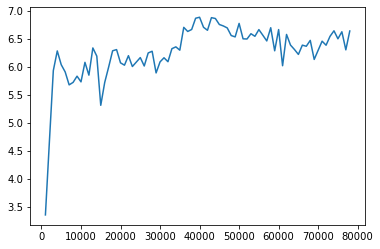

In [69]:
print(mean_confidence_interval(avg, confidence=0.95))
print(max(avg))
plt.plot(steps, avg)

In [72]:
total_return = 0.0
episodes = 1
for _ in range(episodes):
    time_step = eval_env.reset()
    episode_return = 0.0
    while not time_step.is_last():
        actions = []
        for i in range(nb_agents):
            actions.append(eval_policies[i].action(time_step).action.numpy()[0])
        actions = tf.convert_to_tensor([actions])
        time_step = eval_env.step(actions)
        episode_return += time_step.reward
    print(eval_py_env.paths)
    print(episode_return.numpy()[0])
    print("##################################")
    total_return += episode_return
avg_return = total_return / episodes
print("Moyenne : ", avg_return.numpy()[0])

[[12, 17, 16, 17, 18, 19, 24, 23, 18, 17, 16, 15, 10, 15, 16, 15, 10, 15, 16, 15, 20, 20, 15, 20, 20, 20], [19, 18, 17, 16, 17, 16, 11, 6, 11, 6, 1, 2, 7, 6, 7, 12, 17, 16, 11, 12, 7, 12, 17, 12, 7, 2], [3, 8, 3, 3, 2, 2, 3, 2, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 3, 2, 1, 0, 1, 2, 2, 1], [12, 11, 6, 7, 6, 11, 16, 21, 22, 23, 24, 19, 14, 9, 14, 19, 18, 13, 14, 19, 14, 19, 19, 18, 19, 14]]
6.582293
##################################
Moyenne :  6.582293


In [ ]:
for i in range(nb_agents):
    policies_checkpointers[i].save(global_step=agents_tf[i].train_step_counter)